# Expanding Flexible Energy Storage Across Europe

Flexible electricity storage expansion is the growth of technologies that shift electricity across time: charging when power is abundant and cheap, then discharging when scarce and expensive. It is critical for integrating large renewable generation into the grid, while limiting price volatility and maintaing reliability.

This notebook creates a measure of opportunity for each EU country (excluding Malta and Cyprus due to data limitations). It is a composite score of: 1) EV chargers per million (as a proxy for grid readiness), 2) renewable generation, 3) electricity price variation, 4) negative electricity price instances. All data used is for 2025. 

A mock up of the dashboard is made to ensure the data was in the right format before exporting to be used in Tableau.

## **Section 1️⃣: Loading packages and setting functions**

### 1.1 Loading packages

In [1]:
# Import the necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1.2 Set functions

In [2]:
# Function to do basic data exploration for new datasets, as a function in case new data sets are used
def basic_explore(df):
    """
    Basic data exploration of a new dataset using usual functions. 

    Parameters:
    - df (pd.DataFrame): input dataset.

    Returns: 
    - dict containing the shape, dtypes, columns, and head of the dataframe.
    """
    print("Shape:", df.shape, "\n", "\n")
    print("Data types:\n", df.dtypes, "\n", "\n")
    print("Columns:\n", df.columns.tolist(), "\n", "\n")
    print("Head:\n", df.head(), "\n", "\n")
    print("Null Counts\n", df.isnull().sum())

In [3]:
# Function to define a dataset, group by column(s), then count total number and % per category
def group_total_percent(df, group_cols):
    """
    Groups the df by one or more columns, counts rows per category,
    sorts descending, and calculates percentage of total.

    Parameters:
    - df (pd.DataFrame): input dataset
    - group_cols (str or list): column(s) to group by

    Returns:
    - pd.DataFrame: grouped, sorted DataFrame with 'count' and 'percentage' columns
    """
    if isinstance(group_cols, str):
        group_cols = [group_cols]

    # Group by the columns and count rows
    grouped = df.groupby(group_cols).size().reset_index(name='count')

    # Calculate percentage per group
    total = grouped['count'].sum()
    grouped['percentage'] = (grouped['count'] / total) * 100

    # Sort descending by count
    grouped = grouped.sort_values('count', ascending=False).reset_index(drop=True)

    return grouped

## **Section 2️⃣: Loading and cleaning data**

### 2.1 Load hourly day ahead electricity prices

In [4]:
# Load hourly day ahead electricity prices and do basic explore of dataset
prices_raw = pd.read_csv('all_countries.csv')

basic_explore(prices_raw)

Shape: (2766080, 5) 
 

Data types:
 Country              object
ISO3 Code            object
Datetime (UTC)       object
Datetime (Local)     object
Price (EUR/MWhe)    float64
dtype: object 
 

Columns:
 ['Country', 'ISO3 Code', 'Datetime (UTC)', 'Datetime (Local)', 'Price (EUR/MWhe)'] 
 

Head:
    Country ISO3 Code       Datetime (UTC)     Datetime (Local)  \
0  Austria       AUT  2015-01-01 00:00:00  2015-01-01 01:00:00   
1  Belgium       BEL  2015-01-01 00:00:00  2015-01-01 01:00:00   
2  Czechia       CZE  2015-01-01 00:00:00  2015-01-01 01:00:00   
3  Denmark       DNK  2015-01-01 00:00:00  2015-01-01 01:00:00   
4  Estonia       EST  2015-01-01 00:00:00  2015-01-01 02:00:00   

   Price (EUR/MWhe)  
0             22.34  
1             36.56  
2             24.20  
3             18.29  
4             23.37   
 

Null Counts
 Country               0
ISO3 Code             0
Datetime (UTC)        0
Datetime (Local)      0
Price (EUR/MWhe)    426
dtype: int64


In [5]:
# Convert Datetime columns from object to date time
cols = ["Datetime (UTC)", "Datetime (Local)"]
prices_raw[cols] = prices_raw[cols].apply(
    pd.to_datetime, format="%Y-%m-%d %H:%M:%S")

# Check
prices_raw.dtypes

Country                     object
ISO3 Code                   object
Datetime (UTC)      datetime64[ns]
Datetime (Local)    datetime64[ns]
Price (EUR/MWhe)           float64
dtype: object

In [6]:
# Check if any negative prices
(prices_raw["Price (EUR/MWhe)"] < 0).sum()

np.int64(25682)

In [7]:
# Check number of negative price incidents by country
prices_raw[prices_raw["Price (EUR/MWhe)"] < 0].groupby("Country")["Price (EUR/MWhe)"].count()

Country
Austria           1258
Belgium           1640
Bulgaria           236
Croatia            672
Czechia           1273
Denmark           1407
Estonia            522
Finland           1690
France            1224
Germany           2258
Greece             136
Hungary            637
Ireland            789
Latvia             458
Lithuania          476
Luxembourg        2258
Netherlands       1613
Norway             278
Poland             559
Portugal           496
Romania            313
Slovakia          1142
Slovenia           690
Spain              891
Sweden            1351
Switzerland        872
United Kingdom     543
Name: Price (EUR/MWhe), dtype: int64

In [8]:
# Rename country column
prices_raw = prices_raw.rename(columns={
    'Country' : 'country'
})

# Rename Czechia
prices_raw["country"] = prices_raw["country"].replace({
    "Czechia": "Czech Republic"
})

### 2.2 Load renewable energy concentration

In [9]:
# Load total and renewable electricity generation and do basic explore of dataset
gen_raw = pd.read_csv('elec_gen.csv')

basic_explore(gen_raw)

Shape: (27825, 19) 
 

Data types:
 STRUCTURE                                                       object
STRUCTURE_ID                                                    object
STRUCTURE_NAME                                                  object
freq                                                            object
Time frequency                                                  object
siec                                                            object
Standard international energy product classification (SIEC)     object
unit                                                            object
Unit of measure                                                 object
geo                                                             object
Geopolitical entity (reporting)                                 object
TIME_PERIOD                                                     object
Time                                                           float64
OBS_VALUE                                

In [10]:
# Drop irrelevant columns
gen_raw = gen_raw[["Geopolitical entity (reporting)", 
                   "TIME_PERIOD", 
                   "Standard international energy product classification (SIEC)",
                   "OBS_VALUE"]]

gen_raw.head()

,Geopolitical entity (reporting),TIME_PERIOD,Standard international energy product classification (SIEC),OBS_VALUE
0,Albania,2018-01,Hydro,884.286
1,Albania,2018-02,Hydro,1054.965
2,Albania,2018-03,Hydro,1291.465
3,Albania,2018-04,Hydro,1174.183
4,Albania,2018-05,Hydro,1007.731


In [11]:
# Rename columns
gen_raw = gen_raw.rename(columns={
    "Geopolitical entity (reporting)": "country",
    "TIME_PERIOD": "date",
    "Standard international energy product classification (SIEC)": "elec_type",
    "OBS_VALUE": "gen_gwh"
})

In [12]:
# Change date into date format
gen_raw["date"] = pd.to_datetime(gen_raw["date"], format="%Y-%m")

gen_raw.dtypes

country              object
date         datetime64[ns]
elec_type            object
gen_gwh             float64
dtype: object

In [13]:
# Rename Czechia
gen_raw["country"] = gen_raw["country"].replace({
    "Czechia": "Czech Republic"
})

### 2.3 Load Number of EV Chargers

In [14]:
# Load number of EV charging points by country and do basic explore of dataset
ev_raw = pd.read_csv('ev_charging_points.csv')

basic_explore(ev_raw)

Shape: (27, 8) 
 

Data types:
 Category                                                              object
Slow AC recharging point, single-phase (P < 7.4kW)                   float64
Medium-speed AC recharging point, triple-phase (7.4kW ≤ P ≤ 22kW)      int64
Fast AC recharging point, triple-phase (P > 22kW)                    float64
Slow DC recharging point (P < 50kW)                                  float64
Fast DC recharging point (50kW ≤ P < 150kW)                          float64
Level 1 - Ultra-fast DC recharging point (150kW ≤ P < 350kW)           int64
Level 2 - Ultra-fast DC recharging point (P ≥ 350kW)                 float64
dtype: object 
 

Columns:
 ['Category', 'Slow AC recharging point, single-phase (P < 7.4kW)', 'Medium-speed AC recharging point, triple-phase (7.4kW ≤ P ≤ 22kW)', 'Fast AC recharging point, triple-phase (P > 22kW)', 'Slow DC recharging point (P < 50kW)', 'Fast DC recharging point (50kW ≤ P < 150kW)', 'Level 1 - Ultra-fast DC recharging point (150kW 

In [15]:
# Convert all figures to float 
ev_raw = ev_raw.astype({"Medium-speed AC recharging point, triple-phase (7.4kW ≤ P ≤ 22kW)" : float,
                        "Level 1 - Ultra-fast DC recharging point (150kW ≤ P < 350kW)" : float
                       })

# Combine into total EV charging points then drop individual counts
cols = ['Slow AC recharging point, single-phase (P < 7.4kW)', 
        'Medium-speed AC recharging point, triple-phase (7.4kW ≤ P ≤ 22kW)', 
        'Fast AC recharging point, triple-phase (P > 22kW)', 
        'Slow DC recharging point (P < 50kW)', 
        'Fast DC recharging point (50kW ≤ P < 150kW)', 
        'Level 1 - Ultra-fast DC recharging point (150kW ≤ P < 350kW)', 
        'Level 2 - Ultra-fast DC recharging point (P ≥ 350kW)']

ev_raw["total_ev"] = ev_raw[cols].sum(axis=1, skipna=True)

ev_raw = ev_raw.drop(columns=cols)

In [16]:
# Rename country column 
ev_raw = ev_raw.rename(columns={
    'Category' : 'country'
})

### 2.4 Load Population Statistics

In [17]:
# Load country population statistics and do basic explore of dataset
pop_raw = pd.read_csv('population.csv')

basic_explore(pop_raw)

Shape: (43, 17) 
 

Data types:
 STRUCTURE                                  object
STRUCTURE_ID                               object
STRUCTURE_NAME                             object
freq                                       object
Time frequency                             object
indic_de                                   object
Demographic indicator                      object
geo                                        object
Geopolitical entity (reporting)            object
TIME_PERIOD                                 int64
Time                                      float64
OBS_VALUE                                   int64
Observation value                         float64
OBS_FLAG                                   object
Observation status (Flag) V2 structure     object
CONF_STATUS                               float64
Confidentiality status (flag)             float64
dtype: object 
 

Columns:
 ['STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'freq', 'Time frequency', 'indic_de', 'De

In [18]:
# Drop unnecessary columns
pop_raw = pop_raw[["Geopolitical entity (reporting)",
                   "OBS_VALUE"]]

# Rename columns
pop_raw = pop_raw.rename(columns={
    "Geopolitical entity (reporting)" : "country",
    "OBS_VALUE" : "population"
})

# Rename Czechia
pop_raw["country"] = pop_raw["country"].replace({
    "Czechia": "Czech Republic"
})

## **Section 3️⃣: Combine into one dataset**

### 3.1 Calculate number of instances of negative prices

In [19]:
# Filter for 2025 and negative prices, then count per unique country
neg_prices = (
    # Create list of unique countries
    pd.DataFrame({'country': prices_raw['country'].unique()})
    .merge(
        # Filter for 2025 only and negative prices only
        prices_raw[(prices_raw['Datetime (UTC)'].dt.year == 2025) & (prices_raw['Price (EUR/MWhe)'] < 0)]
        # Group by country and count number of negative price instances
        .groupby('country').size().reset_index(name='neg_prices_count'),
        on='country',
        how='left'
    )
    # If no negative price instances than fill as 0
    .fillna(0)
)

# Convert count to integer
neg_prices['neg_prices_count'] = neg_prices['neg_prices_count'].astype(int)

basic_explore(neg_prices)

Shape: (31, 2) 
 

Data types:
 country             object
neg_prices_count     int64
dtype: object 
 

Columns:
 ['country', 'neg_prices_count'] 
 

Head:
           country  neg_prices_count
0         Austria               330
1         Belgium               519
2  Czech Republic               322
3         Denmark               338
4         Estonia               198 
 

Null Counts
 country             0
neg_prices_count    0
dtype: int64


### 3.2 Calculate standard deviation of prices

In [20]:
# Filter for 2025 only
prices_2025 = prices_raw[prices_raw['Datetime (UTC)'].dt.year == 2025]

# Compute standard deviation per country
price_std = (
    # Create list of unique countries
    pd.DataFrame({'country': prices_2025['country'].unique()})  
    .merge(
        # Group by country
        prices_2025.groupby('country')['Price (EUR/MWhe)']
        # Calculate standard deviation
        .std().reset_index(name='std_price'),
        on='country',
        how='left'
    ))

basic_explore(price_std)

Shape: (31, 2) 
 

Data types:
 country       object
std_price    float64
dtype: object 
 

Columns:
 ['country', 'std_price'] 
 

Head:
           country  std_price
0         Austria  47.330437
1         Belgium  47.612017
2        Bulgaria  59.227521
3         Croatia  53.488548
4  Czech Republic  49.848821 
 

Null Counts
 country      0
std_price    0
dtype: int64


### 3.3 Calculate renewable concentration

In [21]:
# Filter for 2025
gen_2025 = gen_raw[gen_raw['date'].dt.year == 2025]

# Define renewables
renewables = ['Hydro', 'Geothermal', 'Wind', 'Solar', 'Other renewable energies']

# Sum renewable energy generation per country
ren_gen_only = (
    gen_2025[gen_2025['elec_type'].isin(renewables)]
    .groupby('country')['gen_gwh']
    .sum()
    .reset_index(name='ren_gwh')
)

# Sum total energy generation per country
total_gen = (
    gen_2025[gen_2025['elec_type'] == 'Total']
    .groupby('country')['gen_gwh']
    .sum()
    .reset_index(name='total_gwh')
)

# Merge and calculate % renewable
ren_gen = ren_gen_only.merge(total_gen, on='country')
ren_gen['ren_percent'] = (ren_gen['ren_gwh'] / ren_gen['total_gwh']) * 100

ren_gen.head()

,country,ren_gwh,total_gwh,ren_percent
0,Albania,7328.742,7406.476,98.950459
1,Austria,51809.086,66092.618,78.388612
2,Belgium,22016.900,60903.330,36.150568
3,Bosnia and Herzegovina,4931.748,12135.554,40.638837
4,Bulgaria,9752.834,33346.833,29.246657


### 3.4 Calculate EV charging infrastructure density

In [22]:
# Merge EV and population datasets
ev_combo = pd.merge(ev_raw, pop_raw, left_on='country', right_on='country', how='left')


basic_explore(ev_combo)

Shape: (27, 3) 
 

Data types:
 country        object
total_ev      float64
population      int64
dtype: object 
 

Columns:
 ['country', 'total_ev', 'population'] 
 

Head:
     country  total_ev  population
0   Austria   34706.0     9197213
1   Belgium   98707.0    11900123
2  Bulgaria    4030.0     6437360
3   Croatia    2305.0     3874350
4    Cyprus     761.0      979865 
 

Null Counts
 country       0
total_ev      0
population    0
dtype: int64


In [23]:
# Create EV density column
ev_combo['ev_density'] = ev_combo['total_ev'] / ev_combo['population']

ev_combo.head()

,country,total_ev,population,ev_density
0,Austria,34706.0,9197213,0.003774
1,Belgium,98707.0,11900123,0.008295
2,Bulgaria,4030.0,6437360,0.000626
3,Croatia,2305.0,3874350,0.000595
4,Cyprus,761.0,979865,0.000777


In [24]:
# Alter so is EV chargers per 1,000,000 people

# Create population in millions column
ev_combo['population_hunthou'] = ev_combo['population'] / 1000000

# Update ev_density column
ev_combo['ev_density'] = (ev_combo['total_ev'] / ev_combo['population_hunthou']).round(0).astype("Int64")

ev_combo.head()

,country,total_ev,population,ev_density,population_hunthou
0,Austria,34706.0,9197213,3774,9.197213
1,Belgium,98707.0,11900123,8295,11.900123
2,Bulgaria,4030.0,6437360,626,6.437360
3,Croatia,2305.0,3874350,595,3.874350
4,Cyprus,761.0,979865,777,0.979865


### 3.5 Merge all 4 datasets

In [25]:
# Merge
final_data = (ev_combo
              .merge(ren_gen, on='country', how='left')
              .merge(price_std, on='country', how='left')
              .merge(neg_prices, on='country', how='left')
             )

basic_explore(final_data)

Shape: (27, 10) 
 

Data types:
 country                object
total_ev              float64
population              int64
ev_density              Int64
population_hunthou    float64
ren_gwh               float64
total_gwh             float64
ren_percent           float64
std_price             float64
neg_prices_count      float64
dtype: object 
 

Columns:
 ['country', 'total_ev', 'population', 'ev_density', 'population_hunthou', 'ren_gwh', 'total_gwh', 'ren_percent', 'std_price', 'neg_prices_count'] 
 

Head:
     country  total_ev  population  ev_density  population_hunthou    ren_gwh  \
0   Austria   34706.0     9197213        3774            9.197213  51809.086   
1   Belgium   98707.0    11900123        8295           11.900123  22016.900   
2  Bulgaria    4030.0     6437360         626            6.437360   9752.834   
3   Croatia    2305.0     3874350         595            3.874350   8936.416   
4    Cyprus     761.0      979865         777            0.979865   1439.378   

 

In [26]:
# Check instances of null 
final_data[final_data.isnull().any(axis=1)]

,country,total_ev,population,ev_density,population_hunthou,ren_gwh,total_gwh,ren_percent,std_price,neg_prices_count
4,Cyprus,761.0,979865,777,0.979865,1439.378,5222.546,27.560849,NaN,NaN
18,Malta,113.0,574250,197,0.574250,324.957,1991.811,16.314650,NaN,NaN


In [27]:
# Check whether Cyprus and Malta in original prices dataset
prices_raw['country'].unique()

array(['Austria', 'Belgium', 'Czech Republic', 'Denmark', 'Estonia',
       'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Italy',
       'Latvia', 'Lithuania', 'Luxembourg', 'Netherlands', 'Norway',
       'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain',
       'Sweden', 'Switzerland', 'United Kingdom', 'Bulgaria', 'Serbia',
       'Croatia', 'Ireland', 'Montenegro', 'North Macedonia'],
      dtype=object)

In [28]:
# Drop Cyprus and Malta as wholesale electricity data is not available and both small markets
final_data.drop(final_data[final_data['country'].isin(['Cyprus', 'Malta'])].index, inplace=True)

final_data = final_data.reset_index(drop=True)

final_data.head(30)

,country,total_ev,population,ev_density,population_hunthou,ren_gwh,total_gwh,ren_percent,std_price,neg_prices_count
0,Austria,34706.0,9197213,3774,9.197213,51809.086,66092.618,78.388612,47.330437,330.0
1,Belgium,98707.0,11900123,8295,11.900123,22016.900,60903.330,36.150568,47.612017,519.0
2,Bulgaria,4030.0,6437360,626,6.437360,9752.834,33346.833,29.246657,59.227521,170.0
3,Croatia,2305.0,3874350,595,3.874350,8936.416,12586.941,70.997520,53.488548,257.0
4,Czech Republic,7574.0,10909500,694,10.909500,7141.933,64688.901,11.040430,49.848821,322.0
5,Denmark,50338.0,5992734,8400,5.992734,21394.531,28857.946,74.137400,50.533311,338.0
6,Estonia,1976.0,1369995,1442,1.369995,2310.000,4895.777,47.183522,73.392525,198.0
7,Finland,19806.0,5635971,3514,5.635971,31706.000,71145.000,44.565324,52.679192,457.0
8,France,186717.0,68635943,2720,68.635943,117664.428,442928.977,26.565078,46.373392,507.0
9,Germany,200830.0,83577140,2403,83.577140,222381.719,408772.466,54.402323,50.811859,502.0


In [29]:
# Check Italy no negative price instances
prices_2025[prices_2025['country'] == 'Italy'].sort_values('Price (EUR/MWhe)').head()

,country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe)
2660308,Italy,ITA,2025-09-14 12:00:00,2025-09-14 14:00:00,10.00
2660277,Italy,ITA,2025-09-14 11:00:00,2025-09-14 13:00:00,10.00
2675636,Italy,ITA,2025-10-05 13:00:00,2025-10-05 15:00:00,10.56
2660339,Italy,ITA,2025-09-14 13:00:00,2025-09-14 15:00:00,15.00
2675608,Italy,ITA,2025-10-05 12:00:00,2025-10-05 14:00:00,15.87


### 3.6 Scale Key Variables and Make Composite Score

* Given extremely skewed distribution of the variables, Robust Scaler was applied then variables were mapped on a 1-25 scale.
* Total opportunity score was measured out of 100, as a sum of individual metrics.

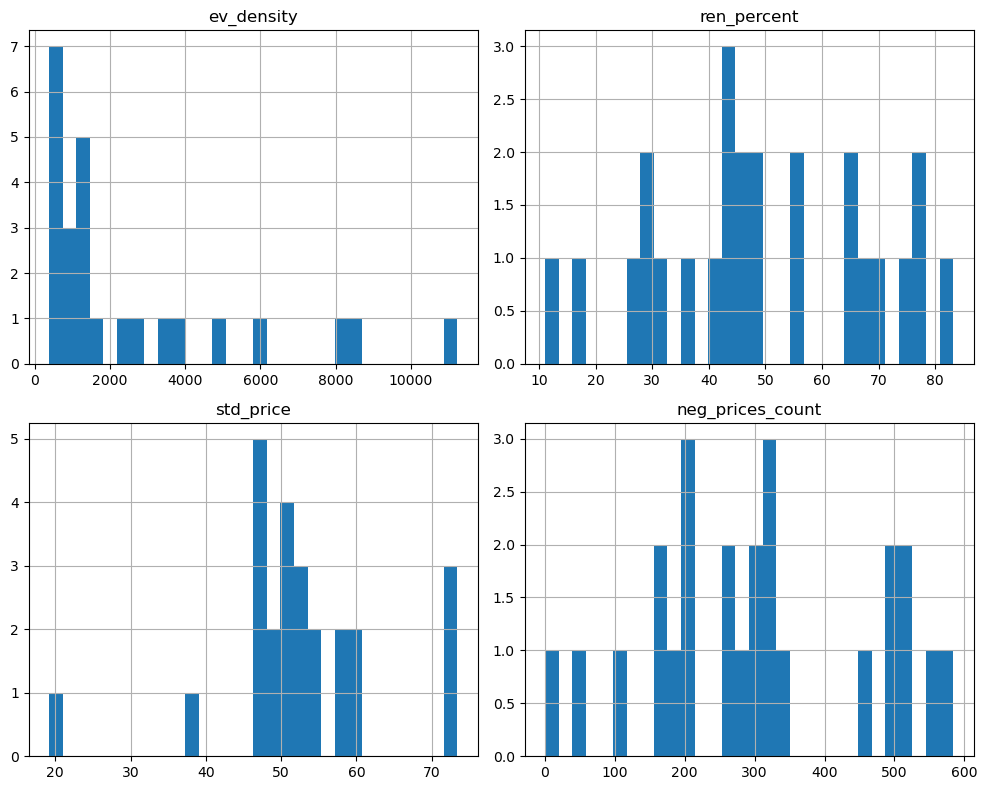

In [30]:
# Check distribution of all 4 variables
cols = ['ev_density', 'ren_percent', 'std_price', 'neg_prices_count']

final_data[cols].hist(bins=30, figsize=(10, 8))
plt.tight_layout()
plt.show()

In [31]:
# Needs full rescaling given skewed distributions
from sklearn.preprocessing import RobustScaler

cols = ['ev_density','ren_percent','std_price','neg_prices_count']

scaler = RobustScaler()
scaled = scaler.fit_transform(final_data[cols])

data_scaled = pd.DataFrame(scaled, columns=cols)

data_scaled.head(30)

,ev_density,ren_percent,std_price,neg_prices_count
0,0.921758,1.078757,-0.398270,0.118774
1,2.536977,-0.342519,-0.368787,0.842912
2,-0.202930,-0.574831,0.847448,-0.494253
3,-0.214005,0.830053,0.246532,-0.160920
4,-0.178635,-1.187456,-0.134576,0.088123
5,2.574491,0.935708,-0.062904,0.149425
6,0.088603,0.028731,2.330636,-0.386973
7,0.828867,-0.059370,0.161786,0.605364
8,0.545195,-0.665064,-0.498481,0.796935
9,0.431940,0.271638,-0.033738,0.777778


In [32]:
# Rescale to 1-25 to create 100 composite score
data_scaled_to25 = (data_scaled - data_scaled.min()) / (data_scaled.max() - data_scaled.min()) * 25

# Rename for clarity
data_scaled_to25 = data_scaled_to25.add_suffix('_score')

# Calculate composite score
data_scaled_to25['total_score'] = data_scaled_to25.sum(axis=1)

# Merge back into main dataframe
final_data = final_data.merge(data_scaled_to25, left_index=True, right_index=True, how='left')

final_data.head(30)

,country,total_ev,population,ev_density,population_hunthou,ren_gwh,total_gwh,ren_percent,std_price,neg_prices_count,ev_density_score,ren_percent_score,std_price_score,neg_prices_count_score,total_score
0,Austria,34706.0,9197213,3774,9.197213,51809.086,66092.618,78.388612,47.330437,330.0,7.821846,23.333315,12.985533,14.126712,58.267407
1,Belgium,98707.0,11900123,8295,11.900123,22016.900,60903.330,36.150568,47.612017,519.0,18.222601,8.699608,13.115340,22.217466,62.255014
2,Bulgaria,4030.0,6437360,626,6.437360,9752.834,33346.833,29.246657,59.227521,170.0,0.579737,6.307693,18.470018,7.277397,32.634845
3,Croatia,2305.0,3874350,595,3.874350,8936.416,12586.941,70.997520,53.488548,257.0,0.508420,20.772612,15.824386,11.001712,48.107130
4,Czech Republic,7574.0,10909500,694,10.909500,7141.933,64688.901,11.040430,49.848821,322.0,0.736174,0.000000,14.146493,13.784247,28.666914
5,Denmark,50338.0,5992734,8400,5.992734,21394.531,28857.946,74.137400,50.533311,338.0,18.464158,21.860449,14.462039,14.469178,69.255824
6,Estonia,1976.0,1369995,1442,1.369995,2310.000,4895.777,47.183522,73.392525,198.0,2.456980,12.522062,25.000000,8.476027,48.455070
7,Finland,19806.0,5635971,3514,5.635971,31706.000,71145.000,44.565324,52.679192,457.0,7.223705,11.614967,15.451278,19.563356,53.853306
8,France,186717.0,68635943,2720,68.635943,117664.428,442928.977,26.565078,46.373392,507.0,5.397074,5.378638,12.544342,21.703767,45.023821
9,Germany,200830.0,83577140,2403,83.577140,222381.719,408772.466,54.402323,50.811859,502.0,4.667802,15.023074,14.590448,21.489726,55.771050


### 3.7 Save final data

In [33]:
# Save to CSV
final_data.to_csv("final_data.csv", index=False)

## Section 4️⃣: Building the Map

### 4.1 Load the relevant packages

In [34]:
!pip install plotly dash

import plotly.express as px
from dash import Dash, dcc, html, Input, Output

In [35]:
import plotly.graph_objects as go

### 4.2 Map mock up (to be built in Tableau)

In [37]:
app = Dash(__name__)
server = app.server  # Needed for hosting

# ---- SIDEBAR ----
sidebar = html.Div(
    style={
        "width": "350px",
        "padding": "15px",
        "backgroundColor": "#d9f2e6",
        "color": "#003d2e",
        "fontFamily": "Arial"
    },
    children=[
        html.H3("Composite Score Breakdown"),

        html.B("1) Market readiness"),
        html.Ul([
            html.Li([html.U("EV charger density"), ": EV chargers per million people, used as a proxy for investment into flexible electricity investment"]),
            html.Li([html.U("Share of renewable electricity generation"), ": renewables as a % of total electricity generation, used as a measure of exposure to renewable electricity fluctuations"])
        ]),

        html.B("2) Market benefits"),
        html.Ul([
            html.Li([html.U("Electricity price variation"), ": the standard deviation of day-ahead electricity prices in 2025, used as a measure of opportunity for flexible pricing"]),
            html.Li([html.U("Frequency of negative electricity prices"), ": instances of negative electricity prices in 2025, used as a measure of potential renewable oversupply,"])
        ]),

        html.Hr(),
        html.P("Each variable was scaled and then mapped to a 1–25 score. Total composite score is out of 100."),
        html.Hr(),

        html.Label("Colour map by:"),
        dcc.Dropdown(
            id="metric-dropdown",
            options=[
                {"label": "Total composite score", "value": "total_score"},
                {"label": "EV density score", "value": "ev_density_score"},
                {"label": "Renewable electricity score", "value": "ren_percent_score"},
                {"label": "Electricity price score", "value": "std_price_score"},
                {"label": "Negative price frequency score", "value": "neg_prices_count_score"},
            ],
            value="total_score",
            clearable=False
        ),
    ]
)

# ---- APP LAYOUT ----
app.layout = html.Div([

    html.Div(
        "Opportunity for Flexible Energy Storage Expansion in Europe",
        style={
            "backgroundColor": "#2f6f55",
            "color": "white",
            "padding": "15px",
            "fontSize": "24px",
            "fontWeight": "bold",
            "fontFamily": "Arial",
            "textAlign": "center"
        }
    ),

    html.Div(
        style={"display": "flex", "height": "calc(100vh - 60px)"},
        children=[
            sidebar,
            html.Div(style={"flex": "1"}, children=[
                dcc.Graph(id="map-graph", style={"height": "100%"})
            ])
        ]
    )
])

# ---- CALLBACK ----
@app.callback(
    Output("map-graph", "figure"),
    Input("metric-dropdown", "value")
)
def update_map(selected_metric):

    fig = px.choropleth(
        final_data,
        geojson="https://raw.githubusercontent.com/leakyMirror/map-of-europe/master/GeoJSON/europe.geojson",
        locations="country",
        featureidkey="properties.NAME",

        color=selected_metric,
        color_continuous_scale="Greens",

        hover_name="country",
        custom_data=["ren_percent", "ev_density", "std_price", "neg_prices_count"]
    )

    fig.update_traces(
        marker_line_color="grey",
        marker_line_width=0.8,
        hovertemplate=
        "<b>%{location}: %{z:.0f}</b><br><br>"
        "% Renewable Elec Gen: %{customdata[0]:.1f}%<br>"
        "EV chargers per person: %{customdata[1]:.0f}<br>"
        "Price variation: %{customdata[2]:.2f}<br>"
        "Negative price events: %{customdata[3]}<br>"
        "<extra></extra>"
    )

    fig.update_layout(
        geo=dict(
            projection_type="natural earth",
            showland=True,
            landcolor="#f7f7f7",
            showocean=False,
            showlakes=False,
            showcoastlines=False,
            showcountries=False,
            showframe=False,          # ✅ removes the border
            fitbounds="locations",
            bgcolor="white"
        ),
        hoverlabel=dict(
            bgcolor="white",
            bordercolor="darkgreen",
            font_size=13,
            align="left"
        ),
        coloraxis_colorbar=dict(
            title="Composite Opportunity Score",
            orientation="h",
            y=-0.15,
            x=0.5,
            xanchor="center",
            len=0.5,
            thickness=12
        ),
        margin={"r":0,"t":0,"l":0,"b":40},
        paper_bgcolor="white",
        plot_bgcolor="white"
    )

    return fig


if __name__ == "__main__":
    app.run(debug=True)
